# Airbnb in Toronto
How to manage Airbnb rental successfully

## Abstract

In this research, we dived into over 10,000 Airbnb listings in Toronto to discover the key factors that affect the price and review rating score. The goal is to provide some insights for potential and existing Airbnb hosts' decision making process when choosing and managing their properties on the website. 

Since price and review rating score are continuous variables, we applied linear regression and random forest regressor for modeling. The results revealed that **the number of tenants that can be accommodates at the property** would be the key factor that correlates with the price. In terms of review rating score, the two models yielded different results; what could be concluded in general was that **the host's credibility** (license, verified identity, time of being a host) was critical in review rating score. Further research shall be performed with another round(s) of data cleaning and wrangling, for both attributes and output variables. 

## I. Introduction

The data set comes from a website called Insideairbnb (http://insideairbnb.com/get-the-data.html Download: http://data.insideairbnb.com/canada/on/toronto/2022-01-06/data/listings.csv.gz ) According to the description, this data is licensed under a Creative Commons Attribution 4.0 International License, and “is sourced from publicly available information from the Airbnb site. The data has been analyzed, cleansed and aggregated where appropriate to faciliate public discussion.”

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
import re

In [2]:
data_original = pd.read_csv("listings.csv")
data_original.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20220106171358,2022-01-07,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.09
1,8077,https://www.airbnb.com/rooms/8077,20220106171358,2022-01-07,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,...,4.90,4.92,4.83,NaN,t,2,1,1,0,1.12
2,23691,https://www.airbnb.com/rooms/23691,20220106171358,2022-01-07,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,NaN,https://a0.muscache.com/pictures/615528/d09ab3...,93825,https://www.airbnb.com/users/show/93825,...,4.93,4.34,4.73,NaN,t,2,0,2,0,1.54
3,27423,https://www.airbnb.com/rooms/27423,20220106171358,2022-01-07,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,https://a0.muscache.com/pictures/176936/b687ed...,118124,https://www.airbnb.com/users/show/118124,...,5.00,4.82,4.82,NaN,f,1,1,0,0,0.18
4,30931,https://www.airbnb.com/rooms/30931,20220106171358,2022-01-07,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,https://a0.muscache.com/pictures/227971/e8ebd7...,22795,https://www.airbnb.com/users/show/22795,...,NaN,NaN,NaN,NaN,f,2,1,1,0,0.01


In [3]:
data_original.shape

(15435, 74)

The original data set contains 15,435 rows and 74 attributes. The details of attributes will be discussed in Exploratory Data Analysis session. 

## II. Exploratory Data Analysis

In [4]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15435 entries, 0 to 15434
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            15435 non-null  int64  
 1   listing_url                                   15435 non-null  object 
 2   scrape_id                                     15435 non-null  int64  
 3   last_scraped                                  15435 non-null  object 
 4   name                                          15434 non-null  object 
 5   description                                   14965 non-null  object 
 6   neighborhood_overview                         9298 non-null   object 
 7   picture_url                                   15435 non-null  object 
 8   host_id                                       15435 non-null  int64  
 9   host_url                                      15435 non-null 

The attributes can be categorized into 6 categories by their nature, as well as corresponding to the users’ journey when making a reservation on Airbnb.

- Property information: property type, location, for how many tenants, amenities, etc. The basic information you would look into and search for. 
- Factors about booking: minimum and maximum nights, instant bookable or not, whether it has license or not. A step forward when you check the listings you like. 
- Occupancy: at the time of scraping, can we book this listing? Is it available in the next 30 to 90 days? 
- Reviews from other users: how many reviews and what’s the score? When is the first and last review? What’s the scores in detail (accuracy, cleanliness, checkin, etc.)?
- Profile of the host: is the host trustworthy? Are they verified? Superhost? How many listings does he/she have? etc.

Therefore, we can make use of the data set, with necessary cleaning and wrangling, to test our assumptions and answer questions:

### Question 1: Are there any correlations between some features and pricing?

This question might be proposed by potential hosts, those who are interested in real estate investment and making their properties for Airbnb rentals with high price. The correlation part may also be insightful for potential tenants when looking for cheap Airbnb choices in the city.

### Question 2: What are the key attributes that makes a successful Airbnb listing in Toronto? 

This question might be valuable for existing hosts, those who would like to improve their performance on Airbnb. It is a pity that we don’t have direct data of occupancy or booking transactions, therefore we cannot calculate the annual revenue. In this question we will arbitrarily evaluate "successful" by "review_scores_rating", the reputation or credit of the listing.

## III. Data Cleaning

### III-1. Remove excessive attributes

It comes with attributes that may be hard to analyze at current stage, such “listing_url”, “pictures_url”, “host_url”, etc. And there is a few attributed that were added by the Inside Airbnb scraper team, such as “scraper_id”, “last_scraped”, “calender_update”, “neighbourhood_group_cleansed”, etc. 

Most of these fields contain the same value or null value, so we can exclude them and keep the following attributes for now until further processing.

In [5]:
data_cleaned_1 = data_original[data_original.columns[~data_original.columns.isin(['listing_url',
                                                                                    'scrape_id', 
                                                                                    'last_scraped',
                                                                                    'picture_url',
                                                                                    'host_url',
                                                                                    'host_thumbnail_url',
                                                                                    'host_picture_url',
                                                                                    'neighbourhood',
                                                                                    'neighbourhood_group_cleansed',
                                                                                    'bathrooms', 
                                                                                    'calendar_updated',
                                                                                    'minimum_nights',
                                                                                    'maximum_nights',
                                                                                    'minimum_minimum_nights',
                                                                                    'maximum_minimum_nights',
                                                                                    'minimum_maximum_nights',
                                                                                    'maximum_maximum_nights',
                                                                                    'calendar_updated',
                                                                                    'calendar_last_scraped'])]]
data_cleaned_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15435 entries, 0 to 15434
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            15435 non-null  int64  
 1   name                                          15434 non-null  object 
 2   description                                   14965 non-null  object 
 3   neighborhood_overview                         9298 non-null   object 
 4   host_id                                       15435 non-null  int64  
 5   host_name                                     15416 non-null  object 
 6   host_since                                    15416 non-null  object 
 7   host_location                                 15407 non-null  object 
 8   host_about                                    8367 non-null   object 
 9   host_response_time                            9619 non-null  

In [6]:
data_cleaned_1.head()

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,1565,Alexandra,2008-08-08,"Vancouver, British Columbia, Canada","I live in Vancouver, Canada with my husband an...",NaN,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.09
1,8077,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,...,4.90,4.92,4.83,NaN,t,2,1,1,0,1.12
2,23691,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,NaN,93825,Yohan & Sarah,2010-03-15,"Toronto, Ontario, Canada",Welcome to our dwelling place! My wife and I l...,NaN,...,4.93,4.34,4.73,NaN,t,2,0,2,0,1.54
3,27423,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,118124,Brent,2010-05-04,"Toronto, Ontario, Canada",I love to travel and meet new people from arou...,NaN,...,5.00,4.82,4.82,NaN,f,1,1,0,0,0.18
4,30931,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,...,NaN,NaN,NaN,NaN,f,2,1,1,0,0.01


### III-2. Convert date type

E.g. The “price” attribute comes as daily price in local currency, which is string that has “$” and “,”, not numeric data. So we need to convert “price” into float.

In [7]:
data_cleaned_1.loc[:, "price"] = data_cleaned_1["price"].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)
data_cleaned_1.loc[:, "host_response_rate"] = data_cleaned_1["host_response_rate"].str.strip("%").astype(float)
data_cleaned_1.loc[:, "host_acceptance_rate"] = data_cleaned_1["host_acceptance_rate"].str.strip("%").astype(float)
data_cleaned_1[["price", "host_response_rate", "host_acceptance_rate"]]

/Users/lizhaotian/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,price,host_response_rate,host_acceptance_rate
0,469.0,NaN,NaN
1,96.0,NaN,NaN
2,72.0,NaN,NaN
3,45.0,NaN,NaN
4,128.0,NaN,NaN
...,...,...,...
15430,72.0,100.0,100.0
15431,44.0,95.0,86.0
15432,81.0,100.0,100.0
15433,70.0,100.0,96.0


### III-3. Handle outliers

In [8]:
Q1 = data_cleaned_1.quantile(0.25)
Q3 = data_cleaned_1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

id                                              2.666260e+07
host_id                                         1.867110e+08
host_response_rate                              4.000000e+00
host_acceptance_rate                            2.600000e+01
host_listings_count                             3.000000e+00
host_total_listings_count                       3.000000e+00
latitude                                        5.909500e-02
longitude                                       5.081400e-02
accommodates                                    2.000000e+00
bedrooms                                        1.000000e+00
beds                                            1.000000e+00
price                                           9.300000e+01
minimum_nights_avg_ntm                          2.100000e+01
maximum_nights_avg_ntm                          7.600000e+02
availability_30                                 2.500000e+01
availability_60                                 5.300000e+01
availability_90         

<AxesSubplot:xlabel='price'>

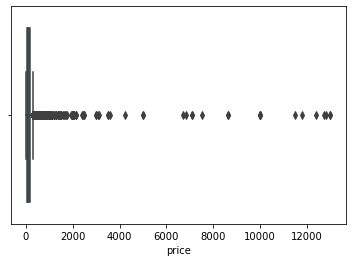

In [9]:
sns.boxplot(x = data_cleaned_1["price"])

After we got numeric values of “price” and ran a boxplot to see the distribution, we found a few outliers somewhere around 4,000, 7,000, 10,000 and even 12,000. These listings should be reviewed individually if necessary:

In [10]:
over_2000 = data_cleaned_1[data_cleaned_1["price"]>2000]
over_2000.head()

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1152,6536680,PanAm Games_ideal central location,Large 4 bedroom home in centrally located area...,NaN,34186216,Bruce,2015-05-25,CA,NaN,NaN,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
1648,8173162,Yonge and bloor apartment,Great location,NaN,28939355,Zhengqin,2015-03-07,"Berkeley, California, United States",Young professional working in New York,NaN,...,NaN,NaN,NaN,NaN,f,1,0,0,1,NaN
1891,9570770,Sunny Central House with Style in Toronto DT,"A quiet community in the heart of Toronto, 8 m...",Walk from 2 different the subway station！ <br ...,44964154,Abby,2015-09-23,"Toronto, Ontario, Canada",Located in a quiet neighborhood in the main do...,NaN,...,4.53,5.00,4.53,NaN,f,11,0,11,0,0.42
2707,13788645,Opulent Toronto Mansion with Pool,Gaze out across the top of Toronto's chic York...,Yorkville is Toronto's upscale neighborhood fo...,9310264,Jordan,2013-10-08,"Toronto, Ontario, Canada",NaN,within a few hours,...,4.88,4.94,4.94,NaN,f,1,1,0,0,0.25
3119,15286188,"DOWNTOWN TORONTO PRIME LOCATION, FULLY FURNISHED!","My place is close to St. Lawrence Market, Ente...",NaN,97297147,Carrie,2016-09-29,"Barrie, Ontario, Canada",NaN,NaN,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN


But for overall analysis, we can exclude them and focus on the entries below 2,000.

In [11]:
data_cleaned_2 = data_cleaned_1[data_cleaned_1["price"]<2000]
data_cleaned_2.head()

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,1565,Alexandra,2008-08-08,"Vancouver, British Columbia, Canada","I live in Vancouver, Canada with my husband an...",NaN,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.09
1,8077,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,...,4.90,4.92,4.83,NaN,t,2,1,1,0,1.12
2,23691,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,NaN,93825,Yohan & Sarah,2010-03-15,"Toronto, Ontario, Canada",Welcome to our dwelling place! My wife and I l...,NaN,...,4.93,4.34,4.73,NaN,t,2,0,2,0,1.54
3,27423,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,118124,Brent,2010-05-04,"Toronto, Ontario, Canada",I love to travel and meet new people from arou...,NaN,...,5.00,4.82,4.82,NaN,f,1,1,0,0,0.18
4,30931,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,...,NaN,NaN,NaN,NaN,f,2,1,1,0,0.01


### III-4. Handle null value

The total number of entries is 15435, but there are some attributes containing less than 15435 non-null values, which means that there exist many null values in columns. There are several conditions that need to be treated differently in certain logic order to avoid redudant tasks:

#### III-4-1. The attributes (columns) containing too many null values and are somewhat dependent on other columns can be excluded. 

E.g. “has_availability” can be represented by ... “neighborhood_overview” shall only be discussed if we find “neighbourhood_cleansed” affects the final result.

In [12]:
data_cleaned_3 = data_cleaned_2[data_cleaned_2.columns[~data_cleaned_2.columns.isin(["has_availability", 
                                                                                     "neighborhood_overview",
                                                                                     "host_neighbourhood",
                                                                                     "number_of_reviews_ltm",
                                                                                     "number_of_reviews_l30d",
                                                                                     "calculated_host_listings_count_entire_homes",
                                                                                     "calculated_host_listings_count_private_rooms",
                                                                                     "calculated_host_listings_count_shared_rooms",
                                                                                     "host_listings_count",
                                                                                     "host_total_listings_count"])]]

#### III-4-2. The entries (rows) containing null values in certain attributes can be excluded. 

For the columns with Non-Null counts that close to the total number of entries. E.g. we will not discuss the listings that has no reviews at all, i.e. contain null value in “review_scores_rating”.

In [13]:
data_cleaned_3 = data_cleaned_3[data_cleaned_3['review_scores_rating'].notna()]
data_cleaned_3 = data_cleaned_3[data_cleaned_3['review_scores_location'].notna()]
data_cleaned_3 = data_cleaned_3[data_cleaned_3['host_has_profile_pic'].notna()]

#### III-4-3. The null values can be replaced by meaningful values.

For the columns with Non-Null counts that much smaller than the total number of entries. E.g. in “license” the null values mean these properties don’t have license, so we can replace them by string “None”.

In [14]:
data_cleaned_3["bedrooms"] = data_cleaned_3["bedrooms"].replace(np.nan, 0)
data_cleaned_3["beds"] = data_cleaned_3["beds"].replace(np.nan, 0)
data_cleaned_3["host_response_rate"] = data_cleaned_3["host_response_rate"].replace(np.nan, 0)
data_cleaned_3["host_acceptance_rate"] = data_cleaned_3["host_acceptance_rate"].replace(np.nan, 0)

In [15]:
data_cleaned_4 = data_cleaned_3.replace(np.nan, "None")
data_cleaned_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11741 entries, 0 to 15428
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11741 non-null  int64  
 1   name                            11741 non-null  object 
 2   description                     11741 non-null  object 
 3   host_id                         11741 non-null  int64  
 4   host_name                       11741 non-null  object 
 5   host_since                      11741 non-null  object 
 6   host_location                   11741 non-null  object 
 7   host_about                      11741 non-null  object 
 8   host_response_time              11741 non-null  object 
 9   host_response_rate              11741 non-null  float64
 10  host_acceptance_rate            11741 non-null  float64
 11  host_is_superhost               11741 non-null  object 
 12  host_verifications              

## IV. Data Wrangling

There is a few attributes that need to be converted into datatypes for easier analysis. 

### IV-1. Convert text into word count

E.g. We may have assumptions like: the more you write about the property and yourself, the more favorable your listing will be. So we can convert "name", "description" and "host_about" into their word count for easier analysis at current stage.

In [16]:
data_cleaned_4["name_count"] = data_cleaned_4["name"].str.split().str.len()
data_cleaned_4["description_count"] = data_cleaned_4["description"].str.split().str.len()
data_cleaned_4["host_about_count"] = data_cleaned_4["host_about"].str.split().str.len()

Same for "amenities": the original datatype in each cell is a list, so we need to convert lists into strings and then do the same word count.

In [17]:
for i in data_cleaned_4.index:
    data_cleaned_4.loc[i, "amenities_str"] = data_cleaned_4.loc[i, "amenities"].strip("[]").replace("\"", "")

In [18]:
data_cleaned_4["amenities_count"] = data_cleaned_4["amenities_str"].str.split(",").str.len()
data_cleaned_4.head()

,id,name,description,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,reviews_per_month,name_count,description_count,host_about_count,amenities_str,amenities_count
0,1419,Beautiful home in amazing area!,"This large, family home is located in one of T...",1565,Alexandra,2008-08-08,"Vancouver, British Columbia, Canada","I live in Vancouver, Canada with my husband an...",None,0.0,...,5.00,None,f,1,0.09,5,172,15,"Dryer, Heating, TV, Smoke alarm, Fire extingui...",14
1,8077,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,None,0.0,...,4.83,None,t,2,1.12,4,170,22,"Cable TV, Heating, Wifi, TV with standard cabl...",12
2,23691,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,93825,Yohan & Sarah,2010-03-15,"Toronto, Ontario, Canada",Welcome to our dwelling place! My wife and I l...,None,0.0,...,4.73,None,t,2,1.54,5,166,154,"Wifi, Smoke alarm, Oven, Cooking basics, Dryer...",31
3,27423,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",118124,Brent,2010-05-04,"Toronto, Ontario, Canada",I love to travel and meet new people from arou...,None,0.0,...,4.82,None,f,1,0.18,7,153,54,"Wifi, Smoke alarm, Oven, Hot water kettle, BBQ...",37
5,40456,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,174063,Denis,2010-07-20,"Toronto, Ontario, Canada",I enjoy hosting travellers from all over the ...,within an hour,100.0,...,4.68,None,f,4,0.81,6,125,9,"Wifi, Smoke alarm, Oven, Shampoo, Cooking basi...",29


### IV-2. Extracting key information

E.g. "host_location" contains information about the city, province/state, and country of the host, and there are 284 unique values. For our analysis, we may ask questions like: are local hosts (in Great Toronto Area) more favorable than hosts in other parts of Canada and in foreign countries? Or hosts in certain countries might be more welcomed because most tenants are from those countries as well? Therefore, we convert the locations that contains "Toronto" into "GTA", and others just keep country names. 

In [19]:
data_cleaned_4["area"] = np.where(data_cleaned_4["host_location"].str.contains("Toronto"), 
                                  "GTA", list(str(val[-1]) for val in data_cleaned_4["host_location"].str.split()))
data_cleaned_4.head()

,id,name,description,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,...,license,instant_bookable,calculated_host_listings_count,reviews_per_month,name_count,description_count,host_about_count,amenities_str,amenities_count,area
0,1419,Beautiful home in amazing area!,"This large, family home is located in one of T...",1565,Alexandra,2008-08-08,"Vancouver, British Columbia, Canada","I live in Vancouver, Canada with my husband an...",None,0.0,...,None,f,1,0.09,5,172,15,"Dryer, Heating, TV, Smoke alarm, Fire extingui...",14,Canada
1,8077,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,None,0.0,...,None,t,2,1.12,4,170,22,"Cable TV, Heating, Wifi, TV with standard cabl...",12,GTA
2,23691,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,93825,Yohan & Sarah,2010-03-15,"Toronto, Ontario, Canada",Welcome to our dwelling place! My wife and I l...,None,0.0,...,None,t,2,1.54,5,166,154,"Wifi, Smoke alarm, Oven, Cooking basics, Dryer...",31,GTA
3,27423,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",118124,Brent,2010-05-04,"Toronto, Ontario, Canada",I love to travel and meet new people from arou...,None,0.0,...,None,f,1,0.18,7,153,54,"Wifi, Smoke alarm, Oven, Hot water kettle, BBQ...",37,GTA
5,40456,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,174063,Denis,2010-07-20,"Toronto, Ontario, Canada",I enjoy hosting travellers from all over the ...,within an hour,100.0,...,None,f,4,0.81,6,125,9,"Wifi, Smoke alarm, Oven, Shampoo, Cooking basi...",29,GTA


### IV-3. Grouping

E.g. "license" contains either the exact serial numbers of license or "None", "Exempt" & "Approved by government". So the listings with exact serial numbers can be grouped into "Yes".

In [20]:
data_cleaned_4.groupby(["license"]).size().nlargest(10).reset_index(name='top10')

,license,top10
0,None,7175
1,Exempt,154
2,Approved by government,59
3,STR-2011-HRWKVL,15
4,STR-2009-FSHDPC,13
5,STR-2011-FZCKVD,13
6,STR-2010-JDHDPM,11
7,STR-2010-JDJKPM,11
8,STR-2011-GJLXVF,11
9,STR-2101-GYTBHH,11


In [21]:
data_cleaned_4.loc[~data_cleaned_4["license"].isin(["None", "Exempt", "Approved by government"]), "license"] = "Yes"
data_cleaned_4.head()

,id,name,description,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,...,license,instant_bookable,calculated_host_listings_count,reviews_per_month,name_count,description_count,host_about_count,amenities_str,amenities_count,area
0,1419,Beautiful home in amazing area!,"This large, family home is located in one of T...",1565,Alexandra,2008-08-08,"Vancouver, British Columbia, Canada","I live in Vancouver, Canada with my husband an...",None,0.0,...,None,f,1,0.09,5,172,15,"Dryer, Heating, TV, Smoke alarm, Fire extingui...",14,Canada
1,8077,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,None,0.0,...,None,t,2,1.12,4,170,22,"Cable TV, Heating, Wifi, TV with standard cabl...",12,GTA
2,23691,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,93825,Yohan & Sarah,2010-03-15,"Toronto, Ontario, Canada",Welcome to our dwelling place! My wife and I l...,None,0.0,...,None,t,2,1.54,5,166,154,"Wifi, Smoke alarm, Oven, Cooking basics, Dryer...",31,GTA
3,27423,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",118124,Brent,2010-05-04,"Toronto, Ontario, Canada",I love to travel and meet new people from arou...,None,0.0,...,None,f,1,0.18,7,153,54,"Wifi, Smoke alarm, Oven, Hot water kettle, BBQ...",37,GTA
5,40456,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,174063,Denis,2010-07-20,"Toronto, Ontario, Canada",I enjoy hosting travellers from all over the ...,within an hour,100.0,...,None,f,4,0.81,6,125,9,"Wifi, Smoke alarm, Oven, Shampoo, Cooking basi...",29,GTA


### IV-4. Calculating timespan

E.g. "host_since" and "first_review" "last_review" can be calculated into timespan for easier analysis.

In [22]:
pd.to_datetime(data_cleaned_4["last_review"])

0       2017-12-04
1       2013-08-27
2       2019-12-22
3       2011-08-30
5       2021-04-30
           ...    
15335   2022-01-06
15340   2022-01-02
15348   2022-01-05
15365   2022-01-04
15428   2022-01-05
Name: last_review, Length: 11741, dtype: datetime64[ns]

In [23]:
data_cleaned_4["review_time"] = (pd.to_datetime(data_cleaned_4["last_review"]) 
                                 - pd.to_datetime(data_cleaned_4["first_review"]))
data_cleaned_4["review_time"] = data_cleaned_4["review_time"].dt.days.astype('int16')
data_cleaned_4["review_time"]

0         869
1        1468
2        3492
3         449
5        3923
         ... 
15335       0
15340       0
15348       1
15365       0
15428       0
Name: review_time, Length: 11741, dtype: int16

In [24]:
d = pd.Timestamp(2022,1,7)

for i in data_cleaned_4.index:
    data_cleaned_4.loc[i, "host_time"] = d - pd.to_datetime(data_cleaned_4.loc[i, "host_since"])

data_cleaned_4["host_time"] = data_cleaned_4["host_time"].dt.days.astype('int16')
data_cleaned_4["host_time"]

0        4900
1        4582
2        4316
3        4266
5        4189
         ... 
15335       9
15340    1554
15348    1717
15365    1717
15428    1472
Name: host_time, Length: 11741, dtype: int16

In [25]:
data_cleaned_5 = data_cleaned_4[["host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_identity_verified", 
 "neighbourhood_cleansed", "room_type", "accommodates", "price", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm","availability_30",
 "number_of_reviews", "review_scores_rating", "license", "instant_bookable", "calculated_host_listings_count",
 "name_count", "description_count", "host_about_count", "amenities_count", "area", "review_time", "host_time"]]

data_cleaned_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11741 entries, 0 to 15428
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_response_rate              11741 non-null  float64
 1   host_acceptance_rate            11741 non-null  float64
 2   host_is_superhost               11741 non-null  object 
 3   host_identity_verified          11741 non-null  object 
 4   neighbourhood_cleansed          11741 non-null  object 
 5   room_type                       11741 non-null  object 
 6   accommodates                    11741 non-null  int64  
 7   price                           11741 non-null  float64
 8   minimum_nights_avg_ntm          11741 non-null  float64
 9   maximum_nights_avg_ntm          11741 non-null  float64
 10  availability_30                 11741 non-null  int64  
 11  number_of_reviews               11741 non-null  int64  
 12  review_scores_rating            

## V. Analysis

### V-1. Simple visualization

What is the most common room type in Toronto on Airbnb?

<AxesSubplot:ylabel='price'>

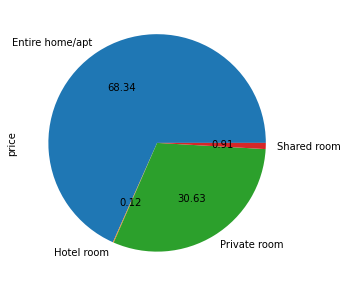

In [26]:
data_cleaned_4.groupby(['room_type'])['price'].count().plot.pie(figsize=(5,5), autopct="%.2f")

Do the listings with higher rating scores also have higher price?

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

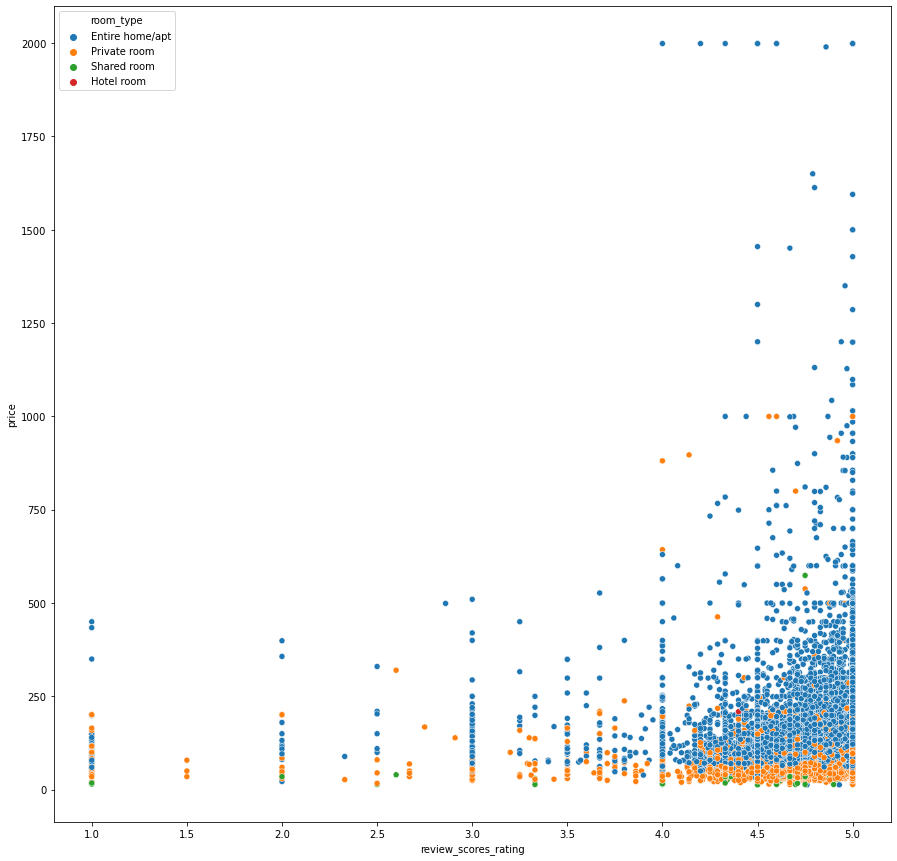

In [27]:
plt.figure(figsize=(15,15))
sns.scatterplot(data = data_cleaned_4, x="review_scores_rating", y="price", hue="room_type")

Would the price be higher for listings that has a long description?

<AxesSubplot:xlabel='description_count', ylabel='price'>

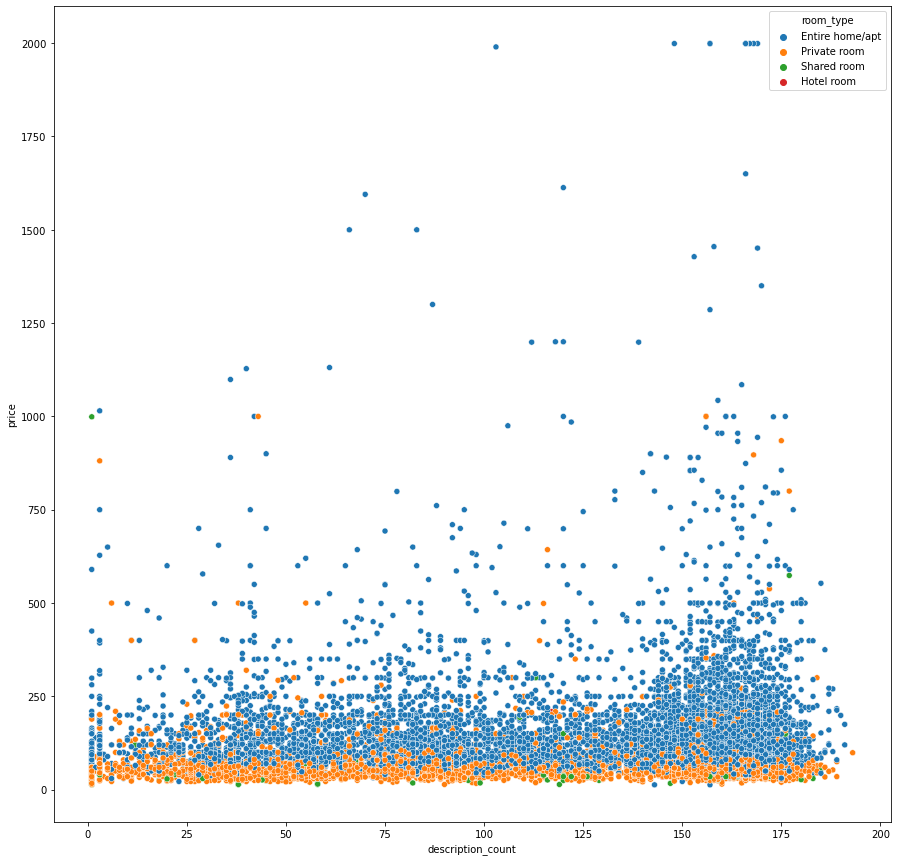

In [28]:
plt.figure(figsize=(15,15))
sns.scatterplot(data = data_cleaned_4, x="description_count", y="price", hue="room_type")

### V-2. Question 1
**Are there any correlations between some features and pricing?**

#### V-2-1. Regression

Before running regression, the nominal attributes in the data set needs to be further processed into numercial values. 

In [29]:
from sklearn import preprocessing

#creating labelEncoder
le = preprocessing.LabelEncoder()

data_cleaned_6 = data_cleaned_5.copy()

# Converting string labels into numbers.
data_cleaned_6.loc[:, "host_is_superhost"] = le.fit_transform(data_cleaned_5["host_is_superhost"])
data_cleaned_6.loc[:, "host_identity_verified"] = le.fit_transform(data_cleaned_5["host_identity_verified"])
data_cleaned_6.loc[:, "neighbourhood_cleansed"] = le.fit_transform(data_cleaned_5["neighbourhood_cleansed"])
data_cleaned_6.loc[:, "room_type"] = le.fit_transform(data_cleaned_5["room_type"])
data_cleaned_6.loc[:, "license"] = le.fit_transform(data_cleaned_5["license"])
data_cleaned_6.loc[:, "instant_bookable"] = le.fit_transform(data_cleaned_5["instant_bookable"])
data_cleaned_6.loc[:, "area"] = le.fit_transform(data_cleaned_5["area"])

Run a feature selection plot to see if there's multicollinearity issues.

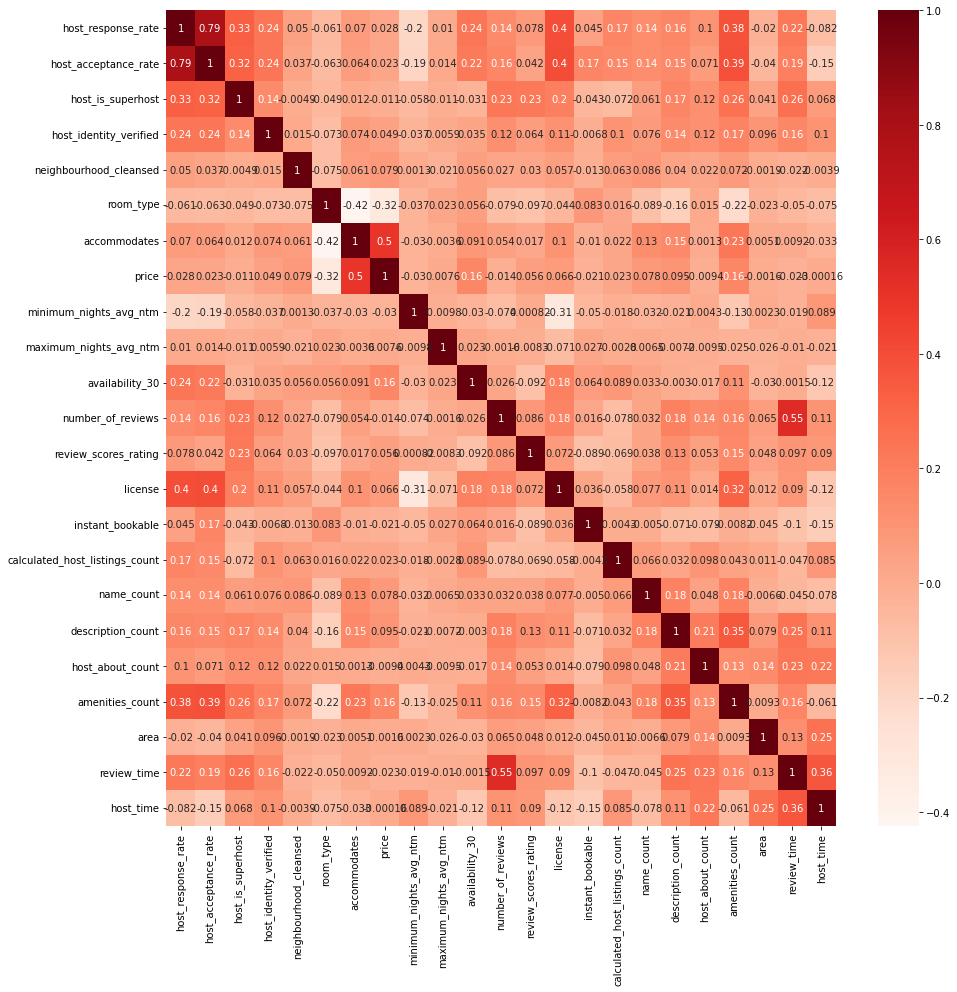

In [30]:
plt.figure(figsize=(15,15))
cor = data_cleaned_6.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from matplotlib import pyplot as plt

X_q1 = data_cleaned_6[data_cleaned_6.columns[~data_cleaned_6.columns.isin(["price"])]]
y_q1 = data_cleaned_6["price"]
X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(X_q1, y_q1, test_size=0.2)

regr_q1 = sm.OLS(y_train_q1, X_train_q1)
pred_price_q1 = regr_q1.fit()
print(pred_price_q1.summary())
y_pred_q1 = pred_price_q1.predict(X_test_q1)
print("\nMSE for OSL Regression model")
print(metrics.mean_squared_error(y_test_q1, y_pred_q1))

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.649
Model:                            OLS   Adj. R-squared (uncentered):              0.648
Method:                 Least Squares   F-statistic:                              787.4
Date:                Fri, 04 Feb 2022   Prob (F-statistic):                        0.00
Time:                        14:12:54   Log-Likelihood:                         -57647.
No. Observations:                9392   AIC:                                  1.153e+05
Df Residuals:                    9370   BIC:                                  1.155e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

#### V-2-2. Random Forest

As price is continous value, we use random forest algorithm to build another model for prediction, and calculate MSE for comparison using the same training vs. testing dataset.

In [32]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, classification_report

regressor_q1 = RandomForestRegressor(n_estimators = 50, random_state = 0)
regressor_q1.fit(X_train_q1, y_train_q1)
y_pred_rf_q1 = regressor_q1.predict(X_test_q1)

print("\nMSE for Random Forest Regression model")
print(metrics.mean_squared_error(y_test_q1, y_pred_rf_q1))


MSE for Random Forest Regression model
12397.000894386076


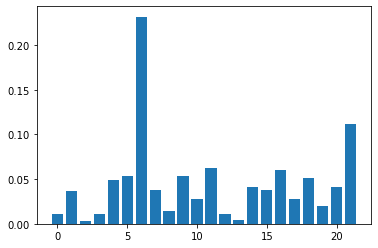

In [33]:
importance_q1 = regressor_q1.feature_importances_
# summarize feature importance

# plot feature importance
pyplot.bar([x for x in range(len(importance_q1))], importance_q1)
pyplot.show()

In [35]:
temp_list_q1 = []

for i,v in enumerate(importance_q1):
    temp_list_q1.append([X_test_q1.columns[i], v])
    
temp_list_q1 = sorted(temp_list_q1, key=lambda x: x[1], reverse=True)
temp_list_q1

[['accommodates', 0.23168637345654325],
 ['host_time', 0.11206378047220932],
 ['review_scores_rating', 0.06215830833734426],
 ['description_count', 0.060687123183360614],
 ['room_type', 0.05396926937168156],
 ['availability_30', 0.05312615952901568],
 ['amenities_count', 0.051323377119384325],
 ['neighbourhood_cleansed', 0.04903516477338342],
 ['review_time', 0.04142794375226722],
 ['calculated_host_listings_count', 0.0414157037138465],
 ['name_count', 0.0381927284703437],
 ['minimum_nights_avg_ntm', 0.037678756740678075],
 ['host_acceptance_rate', 0.03704215135465347],
 ['number_of_reviews', 0.028012226656808633],
 ['host_about_count', 0.027754377397947533],
 ['area', 0.019477930246883813],
 ['maximum_nights_avg_ntm', 0.014291182949679104],
 ['license', 0.011302364166491307],
 ['host_response_rate', 0.011061031948404581],
 ['host_identity_verified', 0.01050039946171904],
 ['instant_bookable', 0.004420035800657538],
 ['host_is_superhost', 0.0033736110966970808]]

As result, the model trained with random forest has a lower MSE, thus higher accuracy than OLS regression. 

According to OLS regression model, the key factors that affect price are:
- accommodates
- room_type
- review_scores_rating
- host_identity_verified

According to random forest regression model, the key factors that affect price are:
- accommodates
- host_time

The MSE of OLS model is lower, indicating relatively better performance.

### V-3. Question 2
**What are the key attributes that makes a successful Airbnb listing in Toronto?**

We'll build model for predicting "review_scores_rating"

In [36]:
X_q2 = data_cleaned_6[data_cleaned_6.columns[~data_cleaned_6.columns.isin(["review_scores_rating"])]]
y_q2 = data_cleaned_6["review_scores_rating"]
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X_q2, y_q2, test_size=0.2)

In [37]:
regr_q2 = sm.OLS(y_train_q2, X_train_q2)
pred_rating = regr_q2.fit()
print(pred_rating.summary())
y_pred_q2 = pred_rating.predict(X_test_q2)
print("\nMSE for OSL Regression model")
print(metrics.mean_squared_error(y_test_q2, y_pred_q2))

                                  OLS Regression Results                                 
Dep. Variable:     review_scores_rating   R-squared (uncentered):                   0.977
Model:                              OLS   Adj. R-squared (uncentered):              0.977
Method:                   Least Squares   F-statistic:                          1.795e+04
Date:                  Fri, 04 Feb 2022   Prob (F-statistic):                        0.00
Time:                          14:13:24   Log-Likelihood:                         -10255.
No. Observations:                  9392   AIC:                                  2.055e+04
Df Residuals:                      9370   BIC:                                  2.071e+04
Df Model:                            22                                                  
Covariance Type:              nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
-

In [38]:
regressor_q2 = RandomForestRegressor(n_estimators = 50, random_state = 0)
regressor_q2.fit(X_train_q2, y_train_q2)
y_pred_rf_q2 = regressor_q2.predict(X_test_q2)
print("\nMSE for Random Forest Regressor model")
print(metrics.mean_squared_error(y_test_q2, y_pred_rf_q2))


MSE for Random Forest Regressor model
0.18484326797786294


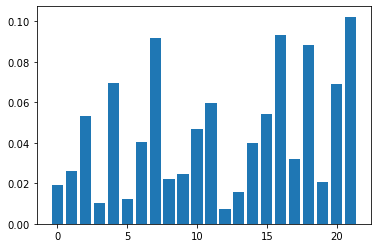

In [39]:
importance_q2 = regressor_q2.feature_importances_

pyplot.bar([x for x in range(len(importance_q2))], importance_q2)
pyplot.show()

In [41]:
temp_list_q2 = []

for i,v in enumerate(importance_q2):
    temp_list_q2.append([X_test_q2.columns[i], v])
    
temp_list_q2 = sorted(temp_list_q2, key=lambda x: x[1], reverse=True)
temp_list_q2

[['host_time', 0.10236353420849835],
 ['description_count', 0.09353992205574559],
 ['price', 0.0919692977417337],
 ['amenities_count', 0.08833043569265692],
 ['neighbourhood_cleansed', 0.06967346485512246],
 ['review_time', 0.06905053801412123],
 ['number_of_reviews', 0.05988213473950951],
 ['name_count', 0.054514399938299415],
 ['host_is_superhost', 0.05328130267831402],
 ['availability_30', 0.04677661538105556],
 ['accommodates', 0.040233191795637745],
 ['calculated_host_listings_count', 0.03969292949507149],
 ['host_about_count', 0.032081914751778746],
 ['host_acceptance_rate', 0.02607735920381793],
 ['maximum_nights_avg_ntm', 0.02461556394086617],
 ['minimum_nights_avg_ntm', 0.022107706006312386],
 ['area', 0.020748265214209846],
 ['host_response_rate', 0.019331911220712494],
 ['instant_bookable', 0.015879902255297684],
 ['room_type', 0.012068038931676182],
 ['host_identity_verified', 0.01022008205113653],
 ['license', 0.007561489828426141]]

As result, the model trained with random forest has a lower MSE, thus higher accuracy than OLS regression.

According to OLS regression model, the key factors that affect review ratings are:

- license
- host_identity_verified
- room_type

According to random forest regression model, the key factors that affect review ratings are:

- host_time
- description_count
- price
- amenities_count

The MSE of random forest model is lower, indicating relatively better performance.

## VI. Limitations

### VI-1. Further data wrangling

On the **attribute** side, there is a few attributes that can be closely associated with our questions but need to be converted into another format in the data set. For example, currently we only considered the number of amenities, but what would be the most essential amenities? Are there any amenities or features that are associated with higher price or rating? 

Another problem detected anecdotally is that some listing descriptions contain non-English text, thus the word count method is different (for counting English words we use space as delimiter). How to deal with non-English charactoers? Shall we just ignore them for easier analysis?

On the **output** side, it is also possible to perform another round of data wrangling. For Question 2, we might have a better way to evaluate “successful” by integrating the following factors:
- high rating (above average), which means recognition from previous tenants and attractiveness for future tenants.
- high number of reviews, which means that the listing has been rented out many times; moreover, we can calculate the annual frequency since we know the time of “first_review” and “last_review”.
- high occupancy rate: no availability in 30, 60 and 90 days. It’s notable that a listing could be unavailable because the host blocked certain days manually, so this factor should be evaluated together with others.

However, the method to integrate these factors is yet to be decided. We could calculate an index, such as weighted average score, to represent the 3 factors. 

### VI-2. Further data cleaning

As many nominal attributes have been converted into numerical values, we may need to perform another round of data cleaning, such as standardization, scaling, normalization, etc.

For exampe, do we need to clean "price" again?

<AxesSubplot:xlabel='price'>

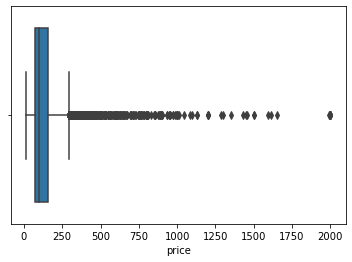

In [42]:
sns.boxplot(x = data_cleaned_4["price"])

## VII. Conclusion

The results from both models revealed that the number of tenants that can be accommodates at the property would be the key factor that correlates with the price, while room type, review scores rating, host's verified identity and host's experience (time of being a host on Airbnb) could also play significant roles in pricing strategy.  

In terms of review rating score, the two models yielded different results; what could be concluded in general was that the host's credibility (license, verified identity, time of being a host) was critical in review rating score. Other features of the listing such as room type, the number of amenities available, the length of description, and price, would affect review rating score to some extend as well. Further research shall be performed with another round(s) of data cleaning and wrangling, for both attributes and output variables.